# Steam Games Review Analysis

# 1. Install and Import Necessary Libray For NLP and Sentiment Analysis

In [1]:
%%capture
!pip install stopwords
!pip install flair
!pip install nltk
!pip install swifter

In [2]:
import pandas as pd
import numpy as np
import flair
from flair.data import Sentence
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
pd.options.display.max_rows = None

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# 2. Import Steam Games Review Dataset

### Here i'm just taking 2% of our data to analyze and to be trained.

In [3]:
rn.seed(a=40)
p = 0.02  
review = pd.read_csv('../input/steam-reviews/dataset.csv',skiprows=lambda i: i>0 and rn.random() > p)
review.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Graphics is not everything! :) Old school love.,1,1
1,10,Counter-Strike,Played it over 2000hours..woah.. all i can say...,1,0
2,10,Counter-Strike,Think you got skills because you came from CS:...,1,1
3,10,Counter-Strike,"Game of my childhood. It was the year 1998, i...",1,0
4,10,Counter-Strike,Where it all started :) A true classic to the ...,1,0


### Here i'm taking 10% of our data to be used as our model validation.

In [4]:
rn.seed(a=40)
q = 0.1  
review_val = pd.read_csv('../input/steam-reviews/dataset.csv',skiprows=lambda i: i>0 and rn.random() > q)
review_val.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,This game saved my virginity.,1,0
1,10,Counter-Strike,Fire in the Hole Simulator 1999,1,0
2,10,Counter-Strike,Best game ever! Started my gaming addiction :D,1,1
3,10,Counter-Strike,'Lock and Load.' 'Go go go!' 'Fire in the hole...,1,0
4,10,Counter-Strike,Nice oldschool game! Counter-Strike is very co...,1,1


In [5]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128153 entries, 0 to 128152
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   app_id        128153 non-null  int64 
 1   app_name      124366 non-null  object
 2   review_text   128004 non-null  object
 3   review_score  128153 non-null  int64 
 4   review_votes  128153 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.9+ MB


In [6]:
review.review_text = review.review_text.astype('str')

# 3. Analysis and Visualization

## 3.1. Distribution of Reviews in Each Sentiment

In [7]:
temp = review.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_text',ascending=False)
temp.style.background_gradient(cmap='Purples')


,review_score,review_text
1,1,104694
0,-1,23459


### We will see the visualization of it.

<AxesSubplot:xlabel='review_score', ylabel='count'>

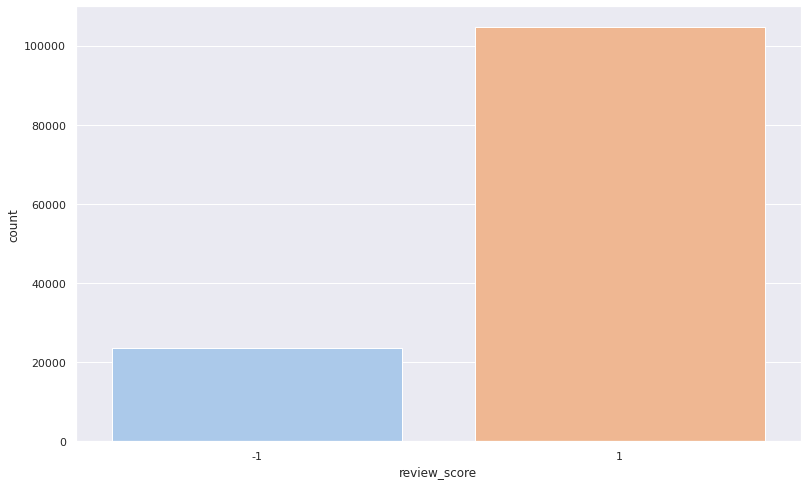

In [8]:
sns.set_theme(style='whitegrid')
sns.set(rc = {'figure.figsize':(13,8)})
sns.set_palette("pastel")
sns.countplot(x='review_score',data=review)

### We can see that there are more positive sentiment reviews than negative sentiment reviews.

## 3.2. WordCloud of Our Review Text

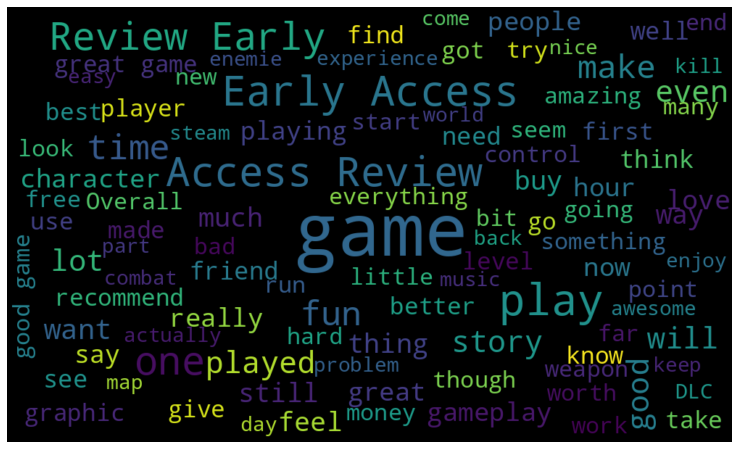

In [9]:
txt = ' '.join(rev for rev in review.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

## 3.3. WordCloud of Each Sentiment Review Text

In [10]:
positive = review[review['review_score']==1]
negative = review[review['review_score']==-1]

## Positive Sentiment Reviews

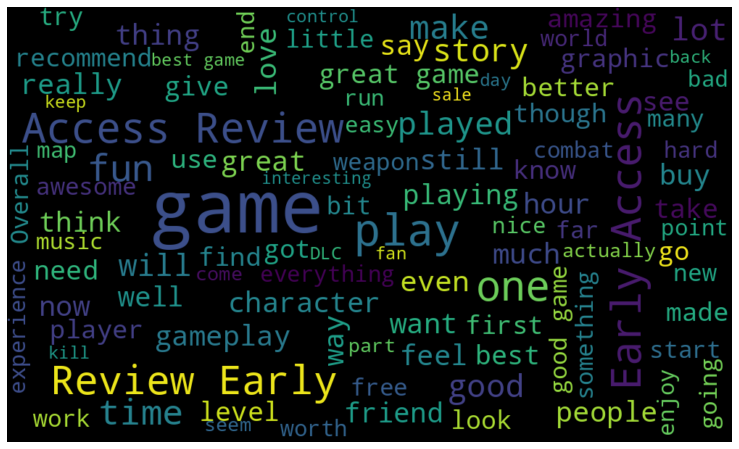

In [11]:
txt = ' '.join(rev for rev in positive.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### We can see that for postive sentiment review, the most common words are 'good', 'great', 'amazing', 'fun' , etc as shown in picture above.

## Negative Sentiment Reviews

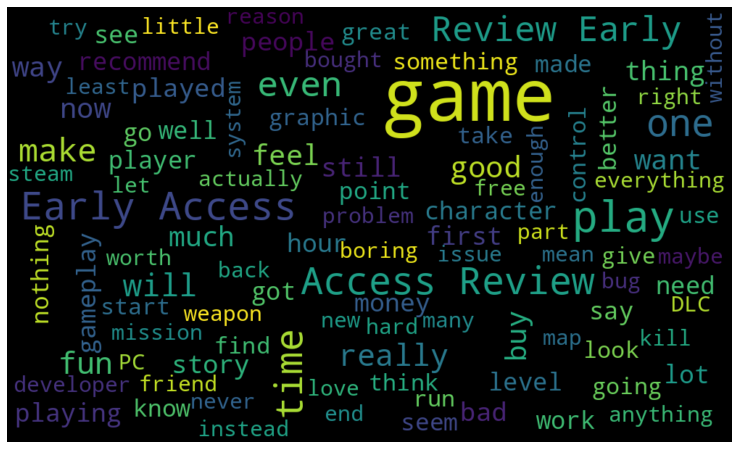

In [12]:
txt = ' '.join(rev for rev in negative.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### And we can see that for negative sentiment review, the most common words are 'boring', 'worth', 'bad', 'game', etc as shown in picture above. It seems for game review, the reviews are a little bit different than reviews for usable or consumable products or goods.

### From the both wordclouds of each sentiment above we can see that there are words like "early" or "access" that dominate our review words. We will drop them.

In [13]:
review = review.drop(review[review.review_text == 'Early Access Review'].index)

## 3.4. Distribution of Number of Review Words

### First we create additional features to count number of words in each review text

In [14]:
review_vis = review.copy()

In [15]:
review_vis['Num_word_review'] = review_vis['review_text'].apply(lambda x:len(str(x).split()))

### Than we can plot them

<AxesSubplot:xlabel='Num_word_review', ylabel='Count'>

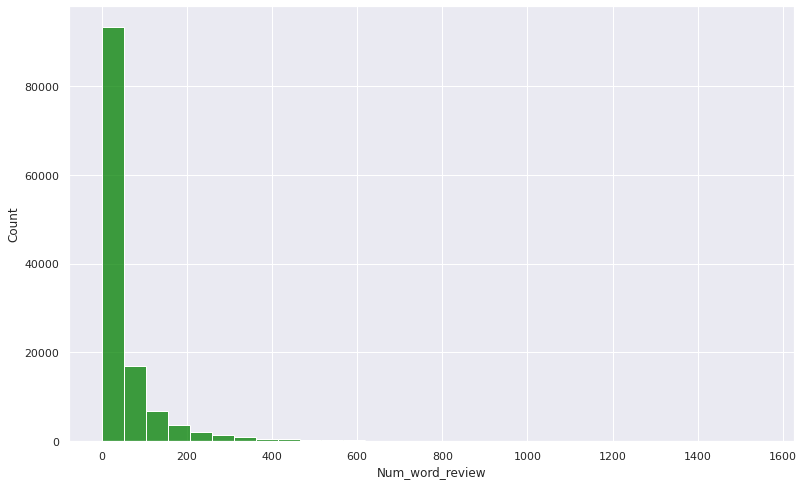

In [16]:
sns.histplot(data=review_vis, x="Num_word_review",bins=30,color='green')

### As we can see that most of our review texts contain 1-200 words.

## 3.5. Distribution of Words in All Review Texts

In [17]:
review_vis['temp_list'] = review_vis['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,276424
1,and,186298
2,a,175388
3,to,174542
4,of,133863
5,is,123576
6,game,113869
7,I,112255
8,you,106759
9,it,85241


### Of course this list still contains stopwords which we have not filtered yet. We will see them later after we filter our review texts.

# 4. Data Cleaning For Sentiment Processing

In [18]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Null values Cleaning

In [19]:
review.isnull().sum()

app_id             0
app_name        3787
review_text        0
review_score       0
review_votes       0
dtype: int64

### But after we've seen that the missing values are only in app name feature, we will ignore them anyway.

### Duplicate Values Removing

In [20]:
review = review.drop_duplicates(keep='first')

In [21]:
review.shape

(109075, 5)

### We make a function to clean some basic characters

In [22]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

### We make function to remove numeric

In [23]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

### We make function to remove emoji

In [24]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

### We make function to unify whitespaces

In [25]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

### We make function to remove symbols

In [26]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

### We make function to remove punctuation

In [27]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

### We make function to remove stopwords

In [28]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

### We make function to use stemming to normalize words

In [29]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def Stemming(text):
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

### Then we combine all the cleaning functions

In [30]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].apply(Stemming)

In [31]:
cleaning(review,'review_text')

In [32]:
review[['review_text']].head(20)

,review_text
0,graphic everyth old school love
1,play hourswoah say isthisi old gold let go eve...
2,think got skill came cs go think got skill cau...
3,game childhood year pentium pc month upgrad dx...
4,start true classic counter strike seri never g...
5,play game year year non steam still amaz fact ...
6,old still best
7,nice game
8,great
9,play awesom game grow oh ya boy miss


### Now all the cleanings are done. We will try to visualize the common words distribution of our review texts. We have done it before but our previous review texts still contain stopwords and punctuations.

In [33]:
review_vis2 = review.copy()

In [34]:
review_vis2['temp_list'] = review_vis2['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,189136
1,play,55324
2,like,39450
3,get,33243
4,one,27061
5,good,26695
6,time,25745
7,fun,24913
8,realli,21775
9,great,21689


### We can plot them

<AxesSubplot:xlabel='count', ylabel='Common_words'>

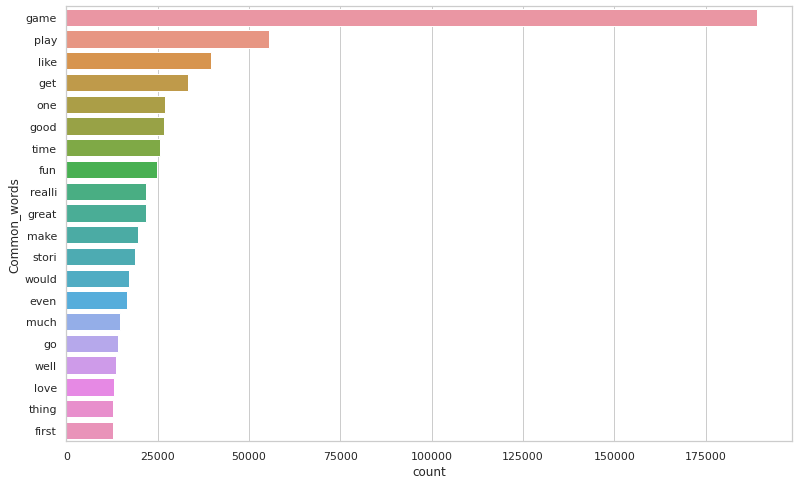

In [35]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp)

### Then We can see that the word "game" , "play" , "like" are the top 3 common words in our review texts.

# 5. Creating Bag of Words and Text Classifier Model

## 5.1. Creating pipeline for tokenizing and modelling

### Here i use count vectorizer for tokenizing and random forest as classifier model.

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english",max_features=3000)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier()),
    ])

In [37]:
X = review['review_text']
y = review['review_score']

## 5.2. Tokenizing and Model Training

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 40,
                                                   test_size = 0.20)


In [39]:
text_classifier = clf.fit(X_train,y_train)

In [40]:
predictions = text_classifier.predict(X_test)

In [41]:
np.unique(predictions)

array([-1,  1])

## 5.3. Model's Performance

In [42]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, roc_auc_score
confusion_matrix(y_test,predictions)

array([[ 1249,  2702],
       [  454, 17410]])

In [43]:
def Confusion_Matrix(y_test,ypred):
    cfmat = confusion_matrix(y_test,ypred)
    print('TN - True Negative {}'.format(cfmat[0,0]))
    print('FP - False Positive {}'.format(cfmat[0,1]))
    print('FN - False Negative {}'.format(cfmat[1,0]))
    print('TP - True Positive {}'.format(cfmat[1,1]))
    print('Accuracy Rate: {}'.format(np.divide(np.sum([cfmat[0,0],cfmat[1,1]]),np.sum(cfmat))))
    print('F1-Score: {}'.format(f1_score(y_test, ypred)))
    print('Misclassification Rate: {}'.format(np.divide(np.sum([cfmat[0,1],cfmat[1,0]]),np.sum(cfmat))))
    print('ROC-AUC {}'.format(roc_auc_score(y_test,ypred)))

In [44]:
Confusion_Matrix(y_test,predictions)

TN - True Negative 1249
FP - False Positive 2702
FN - False Negative 454
TP - True Positive 17410
Accuracy Rate: 0.8553289021315609
F1-Score: 0.9168948809774594
Misclassification Rate: 0.14467109786843915
ROC-AUC 0.6453541298506345


<AxesSubplot:>

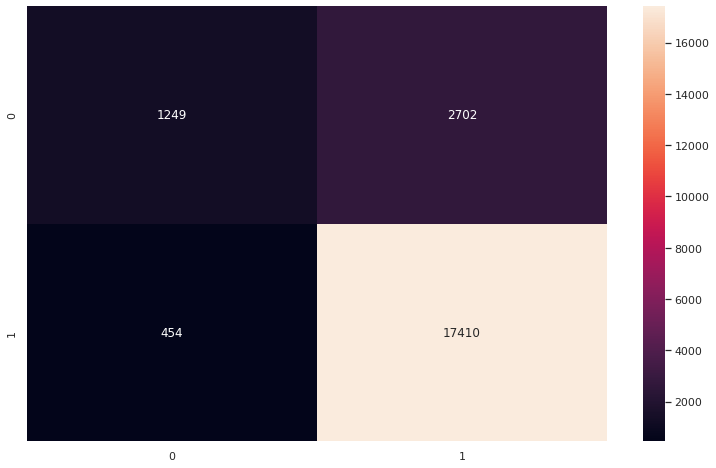

In [45]:
sns.heatmap(confusion_matrix(y_test,predictions),annot=True,fmt='')

### We see from above confusion matrix that our model has accuracy of 85.5 % and F1-Score of 91.68 %. It is pretty good. We also have ROC-AUC score of 0.64 where 0.5< our AUC Score <1. So there is a high chance that the our text classifier model will be able to distinguish the positive sentiment class values from the negative sentiment class values.

## 5.4. Model's performance validation for larger original dataset

### Here we use our validation data which was taken from 10% of our steam review dataset.

In [46]:
review_val.review_text = review_val.review_text.astype('str')
#cleaning(review_val,'review_text')

In [47]:
X_val = review_val['review_text']
y_val = review_val['review_score']

In [48]:
y_pred = text_classifier.predict(X_val)

In [49]:
Confusion_Matrix(y_val,y_pred)

TN - True Negative 19506
FP - False Positive 96823
FN - False Negative 9403
TP - True Positive 515255
Accuracy Rate: 0.8342774502447008
F1-Score: 0.906551741125468
Misclassification Rate: 0.16572254975529924
ROC-AUC 0.5748787235943157


<AxesSubplot:>

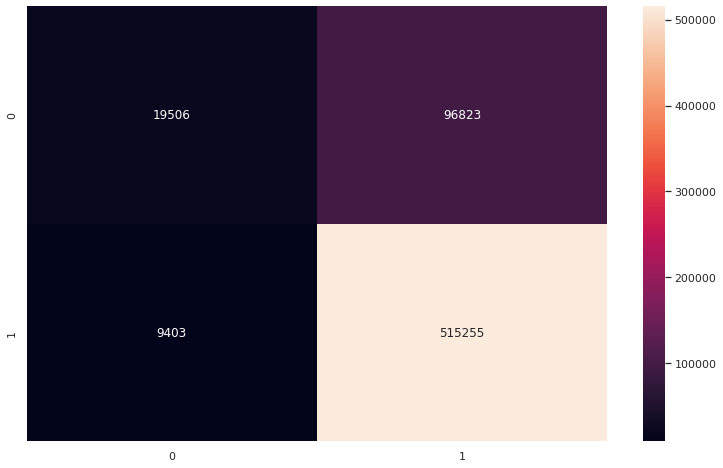

In [50]:
sns.heatmap(confusion_matrix(y_val,y_pred),annot=True,fmt='')

### Same as before, we see from above confusion matrix that our model has accuracy of 83.42% and F1-Score of 90.65%. It is also pretty good when we use our text classifier model on larger data. 

### We also have ROC-AUC score of 0.57 where 0.5< our AUC Score <1. So there is still a high chance that the our text classifier model will be able to distinguish the positive sentiment class values from the negative sentiment class values on larger data.